<center>
<h1>Fake news detection using graph neural network</h1>
<h2>Basic GNN</h2>
<i><h6>Victor GOUBET | Nicholas Tagliapietra | Asma Bakhtiariazad</h6></i>
</center>


----

# Library

In [1]:
import torch
import pickle as pk

from tqdm.notebook import tqdm
from torch.nn import Linear, LogSoftmax
from torch_geometric.loader import DataLoader
from tool_box import plot_hist, ext_UPFD, get_acc
from torch_geometric.nn import GCNConv, global_mean_pool, global_max_pool

# Import datasets

In [2]:
datasets = pk.load(open('../data/datasets.pkl', 'rb'))

# Define the model

In [3]:
class GNN(torch.nn.Module):

    def __init__(self, num_n_feature, num_g_feature, emb_size):
        super(GNN, self).__init__()
        torch.manual_seed(42)
        self.emb_size = emb_size

        self.in_layer = GCNConv(num_n_feature, emb_size)
        self.conv = GCNConv(emb_size, emb_size)
       
       # check if we have graph features to concatenate or not
        i = 2
        if num_g_feature:
             self.lin_g = Linear(num_g_feature, emb_size)
             i = 3

        self.out_layer = Linear(i * emb_size, 2)
        self.act = LogSoftmax(dim=-1)
    
    def forward(self, x, edges_idx, batch_idx, g_features):
        
        x = self.in_layer(x, edges_idx)
        x = self.conv(x, edges_idx)

        flatten = torch.cat([global_mean_pool(x, batch_idx),
                             global_max_pool(x, batch_idx)], axis=1)

        if g_features.size()[-1]:
            g_ft = self.lin_g(g_features)
            flatten = torch.cat([flatten, g_ft], axis=1)

        out = self.act(self.out_layer(flatten))

        return out


# Training

## Define training

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print(f"Training Device: {device}")

Training Device: cuda


In [5]:
@torch.no_grad()
def test_accuracy(model, data):    
    acc = 0
    model.eval()
    data = DataLoader(data, batch_size=128, shuffle=False)
    
    for batch in data:
        batch.to(device)
        
        out = model(batch.x, batch.edge_index, batch.batch, batch.y[:, 1:])
        y_real = batch.y[:, 0].type(torch.int64)

        acc += get_acc(out, y_real)
        
    return round(acc/len(data), 2)

In [6]:
def train_step(model, data, optimizer, loss_f):
    model.train()
    tot_loss, acc = 0, 0
    for batch in data:
        batch.to(device)
        optimizer.zero_grad()

        out = model(batch.x, batch.edge_index, batch.batch, batch.y[:, 1:])
        y_real = batch.y[:, 0].type(torch.int64)
        
        acc += get_acc(out, y_real)
        loss = loss_f(out, y_real) 
        tot_loss += loss.item()

        loss.backward()
        optimizer.step()

    return round(tot_loss/len(data), 2), round(acc/len(data), 2)

In [7]:
@torch.no_grad()
def val_step(model, data, loss_f):
    model.eval()
    tot_loss, acc = 0, 0
    for batch in data:
        batch.to(device)
        
        out = model(batch.x, batch.edge_index, batch.batch, batch.y[:, 1:])
        y_real = batch.y[:, 0].type(torch.int64)

        acc += get_acc(out, y_real)
        tot_loss += loss_f(out, y_real).item()
    return round(tot_loss/len(data), 2), round(acc/len(data), 2)

In [8]:
def train(model, data_train, data_val, epochs=100):
    acc_losses_t, acc_losses_v = [], []
    loss_f = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

    train_loader = DataLoader(data_train, batch_size=128, shuffle=True)
    val_loader = DataLoader(data_val, batch_size=128, shuffle=True)

    for epoch in tqdm(range(epochs)):
        loss_t, acc_t = train_step(model, train_loader, optimizer, loss_f)
        loss_v, acc_v = val_step(model, val_loader, loss_f)
        
        acc_losses_t.append([loss_t, acc_t])
        acc_losses_v.append([loss_v, acc_v])
        if (epoch+1) % 10 == 0:
            print(f'Epochs: {epoch+1} | loss_train={loss_t}  loss_val={loss_v} | acc_train={acc_t}  acc_val={acc_v}')
    return acc_losses_t, acc_losses_v

## Train

In [9]:
models = []
for x in datasets:
    print(f'--> Train on: {x[0]}')
    model = GNN(x[1].num_features, len(x[1].g_features), 100).to(device)
    hist = train(model, x[1], x[2], epochs=100)
    score = test_accuracy(model, x[3])
    models.append([x[0], model, hist, score])

--> Train on: origin


  0%|          | 0/100 [00:00<?, ?it/s]

Epochs: 10 | loss_train=0.51  loss_val=0.5 | acc_train=0.79  acc_val=0.79
Epochs: 20 | loss_train=0.44  loss_val=0.43 | acc_train=0.82  acc_val=0.8
Epochs: 30 | loss_train=0.42  loss_val=0.41 | acc_train=0.82  acc_val=0.84
Epochs: 40 | loss_train=0.42  loss_val=0.42 | acc_train=0.83  acc_val=0.82
Epochs: 50 | loss_train=0.41  loss_val=0.39 | acc_train=0.84  acc_val=0.84
Epochs: 60 | loss_train=0.41  loss_val=0.4 | acc_train=0.83  acc_val=0.85
Epochs: 70 | loss_train=0.4  loss_val=0.37 | acc_train=0.83  acc_val=0.85
Epochs: 80 | loss_train=0.39  loss_val=0.38 | acc_train=0.85  acc_val=0.86
Epochs: 90 | loss_train=0.38  loss_val=0.38 | acc_train=0.85  acc_val=0.84
Epochs: 100 | loss_train=0.37  loss_val=0.37 | acc_train=0.85  acc_val=0.86
--> Train on: dataset1


  0%|          | 0/100 [00:00<?, ?it/s]

Epochs: 10 | loss_train=0.54  loss_val=0.53 | acc_train=0.78  acc_val=0.72
Epochs: 20 | loss_train=0.5  loss_val=0.53 | acc_train=0.78  acc_val=0.82
Epochs: 30 | loss_train=0.52  loss_val=0.52 | acc_train=0.77  acc_val=0.73
Epochs: 40 | loss_train=0.55  loss_val=0.49 | acc_train=0.79  acc_val=0.82
Epochs: 50 | loss_train=0.51  loss_val=0.52 | acc_train=0.77  acc_val=0.81
Epochs: 60 | loss_train=0.52  loss_val=0.5 | acc_train=0.77  acc_val=0.8
Epochs: 70 | loss_train=0.51  loss_val=0.56 | acc_train=0.77  acc_val=0.7
Epochs: 80 | loss_train=0.48  loss_val=0.48 | acc_train=0.79  acc_val=0.78
Epochs: 90 | loss_train=0.48  loss_val=0.5 | acc_train=0.79  acc_val=0.81
Epochs: 100 | loss_train=0.47  loss_val=0.5 | acc_train=0.79  acc_val=0.78
--> Train on: dataset2


  0%|          | 0/100 [00:00<?, ?it/s]

Epochs: 10 | loss_train=0.59  loss_val=0.56 | acc_train=0.76  acc_val=0.72
Epochs: 20 | loss_train=0.54  loss_val=0.56 | acc_train=0.78  acc_val=0.7
Epochs: 30 | loss_train=0.52  loss_val=0.55 | acc_train=0.79  acc_val=0.71
Epochs: 40 | loss_train=0.49  loss_val=0.5 | acc_train=0.8  acc_val=0.81
Epochs: 50 | loss_train=0.47  loss_val=0.47 | acc_train=0.8  acc_val=0.78
Epochs: 60 | loss_train=0.46  loss_val=0.47 | acc_train=0.81  acc_val=0.81
Epochs: 70 | loss_train=0.46  loss_val=0.47 | acc_train=0.8  acc_val=0.76
Epochs: 80 | loss_train=0.46  loss_val=0.47 | acc_train=0.81  acc_val=0.83
Epochs: 90 | loss_train=0.46  loss_val=0.49 | acc_train=0.8  acc_val=0.82
Epochs: 100 | loss_train=0.46  loss_val=0.45 | acc_train=0.8  acc_val=0.82


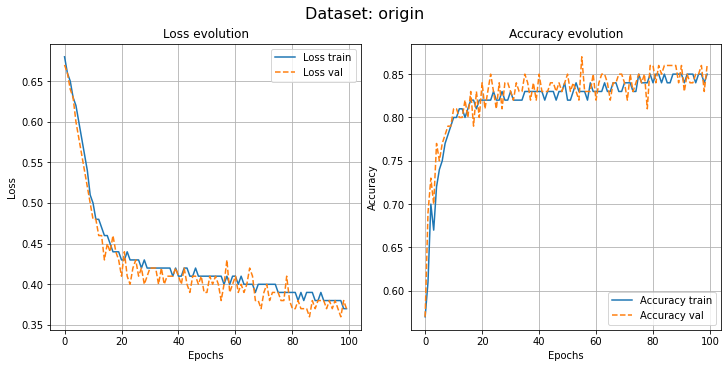

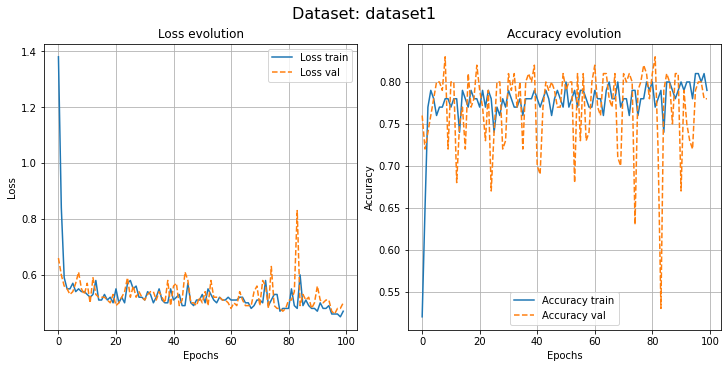

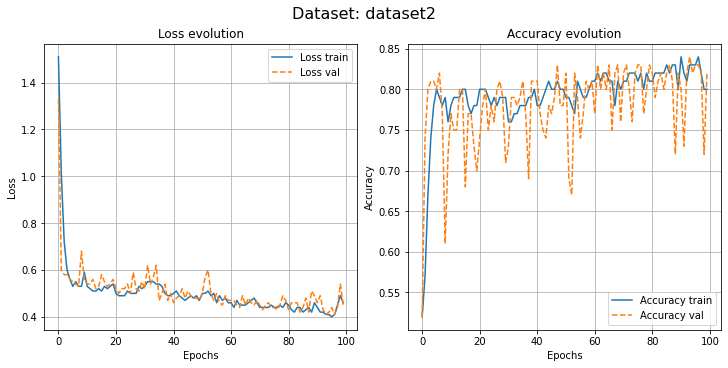

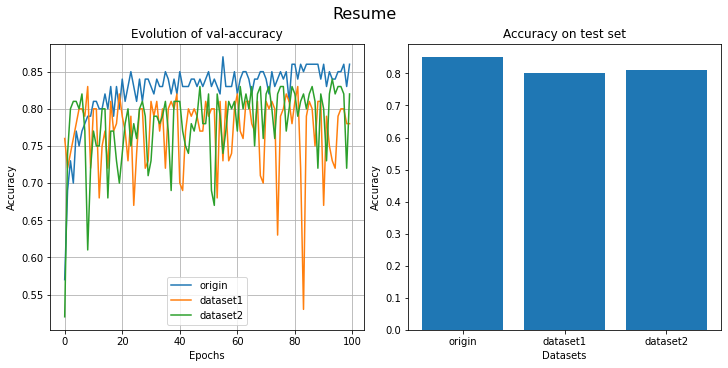

In [10]:
plot_hist(models)